In [7]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


matfile = loadmat('face.mat')
data = matfile['X']

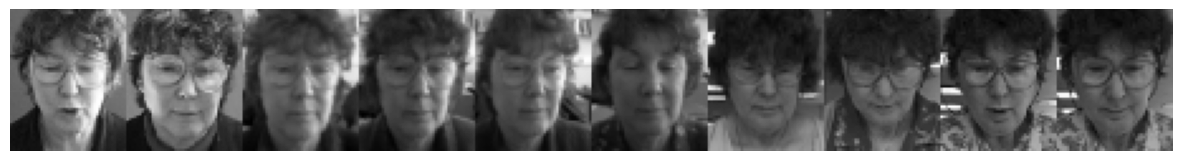

In [31]:
from PIL import Image

def create_image(array, figsize=2):
    """Shows the image, with a fixed size of 46x56 pixels"""
    width = 46
    height = 56
    assert len(array) == width * height, "Incorrect array size"
    img_array = np.zeros([height, width], dtype=np.uint8)
    for pw in range(width):
        for ph in range(height):
            img_array[ph, pw] = array[pw * height + ph]
    #img_array = np.reshape(array, (width, height)).T
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    ax.set_axis_off()
    ax.imshow(img_array, cmap='gray')

def create_image_table(array, img_per_row, mode='L', figsize=15):
    """Create table of images based on data that has multiple images, one in each row"""
    d, N = array.shape
    assert N % img_per_row == 0
    width = 46
    height = 56
    img_per_column = N // img_per_row
    img_array = np.zeros((img_per_column * height, img_per_row * width), dtype=np.uint8)
    for col in range(img_per_column):
        for row in range(img_per_row):
            # add first row of pixels from first image to img_array, then first row of second pic etc.
            image_idx = col * img_per_row + row
            for pw in range(width):
                for ph in range(height):
                    img_array[col * height + ph, row * width + pw] = array[pw * height + ph, image_idx]
    
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    ax.set_axis_off()
    ax.imshow(img_array, cmap='gray')
    #return Image.fromarray(img_array, mode)

create_image_table(data[:, :10], 10, figsize=15)

In [9]:
# Split data into training and testing set. There are 10 images of each face, 520 in total.
# pick first 8 as training set and rest 2 as test set for all faces
d, N = data.shape
train_idx = []
test_idx = []
for i in range(N//10):
    s = i * 10
    train_idx.extend(list(range(s, s+8)))
    test_idx.extend(list(range(s+8, s+10)))


train_data = np.take(data, train_idx, axis=1)
test_data = np.take(data, test_idx, axis=1)

## Standard PCA

Solve the eigenvalue problem for the covariance matrix $S$, where:
$$
S = \frac{1}{N}\sum_{n=1}^{N}(x_n - \bar{x})(x_n - \bar{x})^T
$$
$\bar{x}$ is the mean vector

In [5]:
from sklearn.preprocessing import normalize

# Standard PCA 
def do_pca(data_array):
    """Perform basic pca. Expects inputs to be columns of images"""
    d, N = data_array.shape
    data_mean = np.mean(data_array, axis=1)
    expanded_mean = np.array([data_mean for _ in range(N)]).T  # make (d, N) vector for subraction
    A = data_array - expanded_mean
    S = (1 / N) * (A @ A.T)
    assert S.shape == (d, d)

    # get the eigendecomposition
    (eigvals, eigvecs) = np.linalg.eig(S)
    return (eigvals, eigvecs)

def do_lowdim_pca(data_array):
    """Calculate A^T A instead of AA^T, can be used when N < d"""
    d, N = data_array.shape
    data_mean = np.mean(data_array, axis=1)
    expanded_mean = np.array([data_mean for _ in range(N)]).T
    A = data_array - expanded_mean
    S = (1 / N) * (A.T @ A)
    assert S.shape == (N, N)

    # eigendecomposition
    (eigvals, eigvecs) = np.linalg.eig(S)
    # get the eigvectors of the true covariance matrix by multiplying them with A
    true_eigvecs = A @ eigvecs
    scaled_eigvecs = normalize(true_eigvecs, axis=0)
    return eigvals, scaled_eigvecs


def upscale(array):
    """scale to 0-1 and upscale to 0-255"""
    # make into 2d array if just one image is given
    if len(array.shape) != 2:
        array = np.expand_dims(array, axis=1)
    tmp = MinMaxScaler((0, 255)).fit_transform(array)
    return tmp

In [6]:
eigvals_org, eigvecs_org = do_pca(train_data)
eigvals_low, eigvecs_low = do_lowdim_pca(train_data)


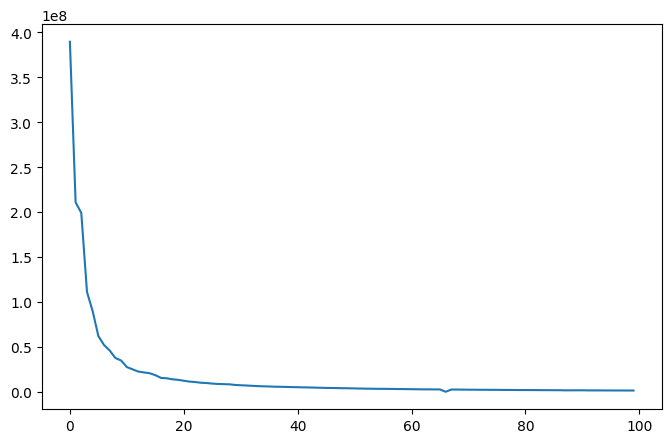

In [155]:
def plot_eigvals(eigvals, up_to=-1):
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(eigvals[:up_to])

plot_eigvals(eigvals_org, up_to=100)

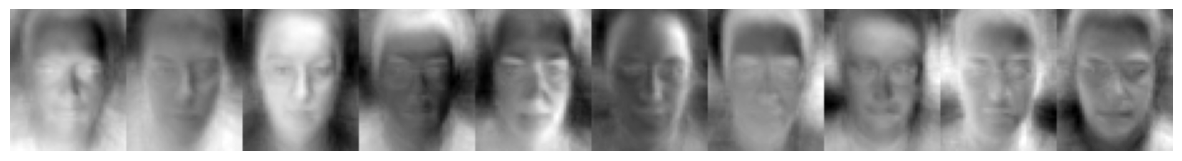

In [11]:
t = np.real(eigvecs_org[:, :10])
create_image_table(upscale(t), 10)

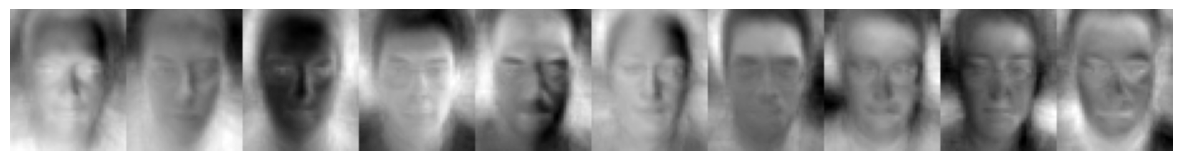

In [16]:
t = np.real(eigvecs_low[:, :10])
create_image_table(upscale(t), 10)

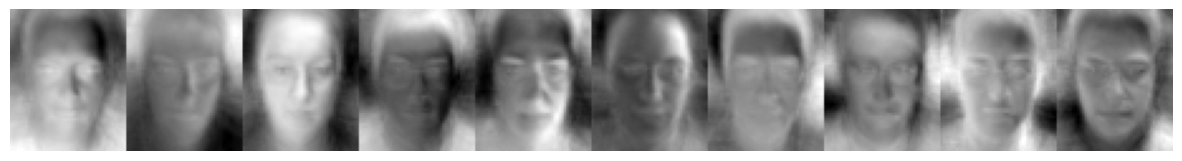

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

def sklearn_pca(data_array):
    pca = PCA()
    pca.fit(data_array.T);
    eigvectors = pca.components_.T
    eigvalues = pca.explained_variance_
    return (eigvalues, eigvectors)

(eigvalues, eigvectors) = sklearn_pca(train_data)
t = eigvectors[:, :10]
create_image_table(upscale(t), 10)
#print(eigvalues[:5])
#create_image_table(upscale(eigvectors[:, :10]), 10)
#plot_eigvals(eigvalues, up_to=50)

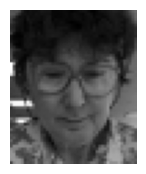

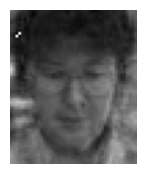

In [28]:
def reconstruct_image(training_data, X, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(training_data.T)
    img = X.reshape(-1, 1).T
    downsampled_img = pca.transform(img)
    upsampled_img = pca.inverse_transform(downsampled_img).T
    return upsampled_img

test_img = test_data[:, 1]
create_image(test_img)
img = reconstruct_image(train_data, test_img, 200)
create_image(img)
